### Imports

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

from ast import literal_eval
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings("ignore")

### Read Embedding File

In [2]:
fpath = 'data/article_title_embeddings.csv'
articles = pd.read_csv(fpath)
articles.columns,\
articles.shape

(Index(['Article Number', 'Article Title', 'Part', 'Part Title',
        'article_title_word_count', 'article_title_embeddings'],
       dtype='object'),
 (498, 6))

In [3]:
articles.iloc[0].T

Article Number                                                              1
Article Title                                Name and territory of the Union.
Part                                                                   PART I
Part Title                              THE UNION AND ITS TERRITORY  ARTICLES
article_title_word_count                                                    6
article_title_embeddings    [-0.0065295227800610195, -0.013792699595786738...
Name: 0, dtype: object

### Clustering Embeddings using K-Means

In [4]:
embedding_matrix = np.array(articles.article_title_embeddings.apply(literal_eval).to_list())
embedding_matrix.shape

(498, 1536)

In [13]:
n_clusters_range = list(range(2, 25))
kmeans_scores = []
silhoutte_scores = []

for n_clusters in tqdm(n_clusters_range):
    kmeans = KMeans(n_clusters = n_clusters, init='k-means++', n_init='auto', random_state=42, max_iter=500)
    cluster_labels = kmeans.fit_predict(embedding_matrix)
    silhouette_avg = silhouette_score(embedding_matrix, cluster_labels)
    kmeans_scores.append(kmeans.inertia_)
    silhoutte_scores.append(silhouette_avg)

  0%|          | 0/23 [00:00<?, ?it/s]

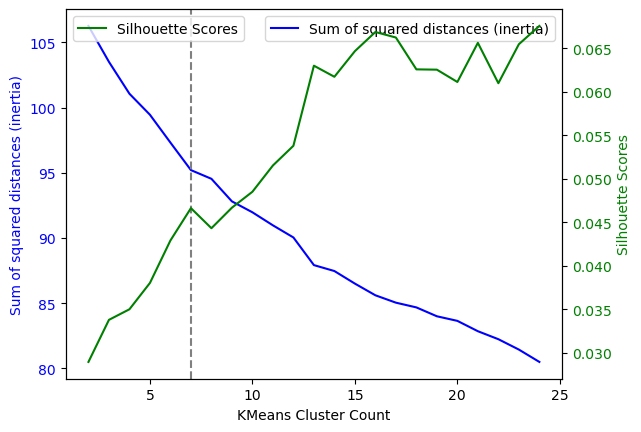

In [19]:
fig, ax1 = plt.subplots()

# plot the sum of squared distances on the first y-axis
sns.lineplot(x=n_clusters_range, y=kmeans_scores, ax=ax1, color='blue', label='Sum of squared distances (inertia)')
ax1.set_xlabel('KMeans Cluster Count')
ax1.set_ylabel('Sum of squared distances (inertia)', color='blue')
ax1.axvline(x=7, color='gray', linestyle='--')
ax1.tick_params(axis='y', labelcolor='blue')

# create a second y-axis for the silhouette scores
ax2 = ax1.twinx()
sns.lineplot(x=n_clusters_range, y=silhoutte_scores, ax=ax2, color='green', label='Silhouette Scores')
ax2.set_ylabel('Silhouette Scores', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# save plot as png Image
plt.savefig('Inertia_Silhouette_Plot.png', bbox_inches='tight')

# show the plot
plt.show()

Selecting K=7 for better interpretability of the clusters even though bigger values give better scores.

In [40]:
k = 7
kmeans = KMeans(n_clusters = k, init='k-means++', n_init='auto', random_state=42, max_iter=500)
cluster_labels = kmeans.fit_transform(embedding_matrix)
articles['Cluster'] = kmeans.labels_

silhouette_avg = silhouette_score(embedding_matrix, kmeans.labels_)
print("For n_clusters =", k, "\nThe average silhouette_score is :", silhouette_avg)

For n_clusters = 7 
The average silhouette_score is : 0.046623891143827735


Cluster-0 size: 67
Cluster-1 size: 71
Cluster-2 size: 90
Cluster-3 size: 70
Cluster-4 size: 45
Cluster-5 size: 43
Cluster-6 size: 112


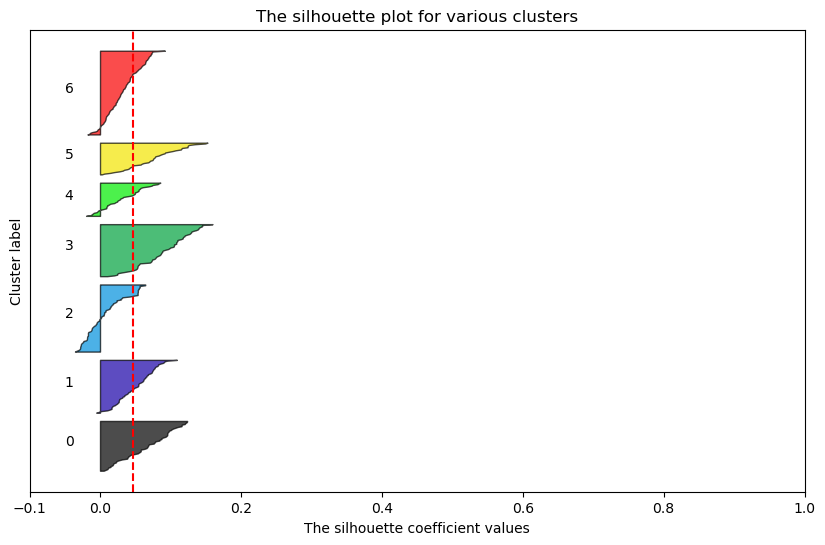

In [41]:
import matplotlib.cm as cm

sample_silhouette_values = silhouette_samples(embedding_matrix, kmeans.labels_)
fig, ax1 = plt.subplots(figsize=(10,6))

y_lower = 10
for i in range(k):
    # get i-th cluster points only
    ith_cluster_silhouette_values = sample_silhouette_values[kmeans.labels_ == i]
    ith_cluster_silhouette_values.sort()

    # number of articles in the cluster
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    print(f'Cluster-{i} size: {size_cluster_i}')

    y_upper = y_lower + size_cluster_i

    # getting new color map for each cluster
    color = cm.nipy_spectral(float(i) / k)
    
    ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                       facecolor=color, edgecolor="black", alpha=0.7)
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    y_lower = y_upper + 10 

ax1.get_yaxis().set_ticks([])
ax1.set_title("The silhouette plot for various clusters")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

### TSNE

In [42]:
%%time

tsne = TSNE(n_components=2, perplexity=15, random_state=42, init='random', learning_rate=200)
vis_dims = tsne.fit_transform(embedding_matrix)
vis_dims.shape

CPU times: total: 13.1 s
Wall time: 998 ms


(498, 2)

### Plotting Embeddings

In [43]:
x = [x for x,y in vis_dims]
y = [y for x,y in vis_dims]
cluster_id = articles['Cluster'].values

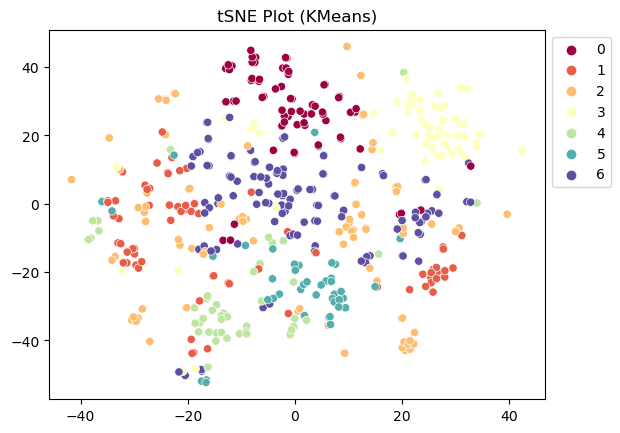

In [45]:
ax = sns.scatterplot(x=x, y=y, hue=cluster_id, palette='Spectral', legend='full')
sns.move_legend(ax, loc='upper left', bbox_to_anchor=(1, 1))
plt.title('tSNE Plot (KMeans)')
plt.savefig('KMeans_tSNE_Plot_v2.png', bbox_inches='tight')
plt.show()

Text(0.5, 1.0, 'tSNE Plot (Article Parts)')

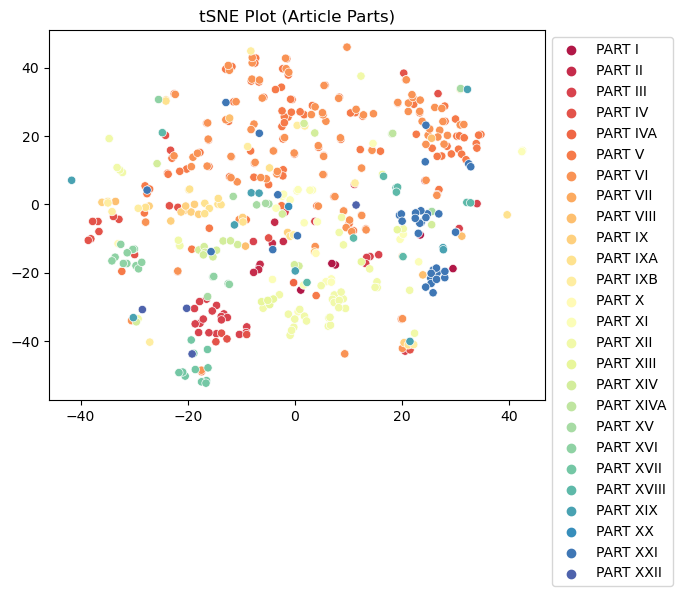

In [46]:
article_parts_as_clusters = articles.Part.values
ax = sns.scatterplot(x=x, y=y, hue=article_parts_as_clusters, palette='Spectral', legend='full')
sns.move_legend(ax, loc='upper left', bbox_to_anchor=(1, 1))
plt.title('tSNE Plot (Article Parts)')

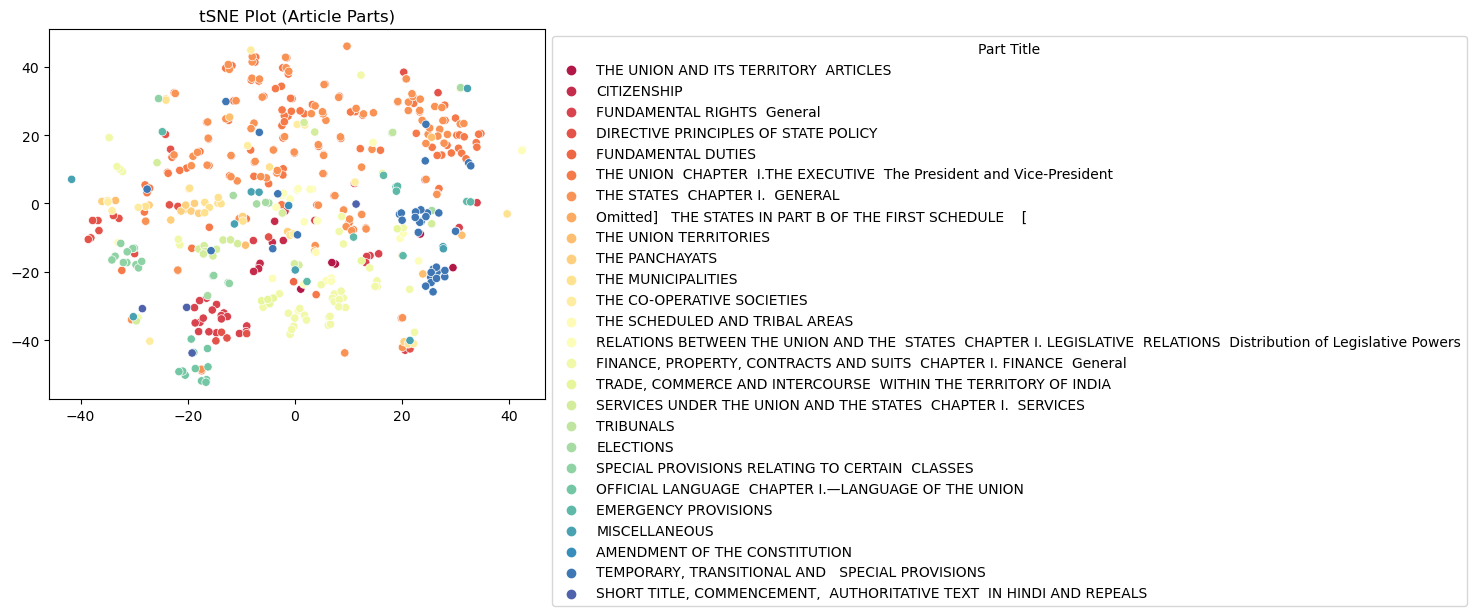

In [47]:
article_parts_title_as_clusters = articles['Part Title']
ax = sns.scatterplot(x=x, y=y, hue=article_parts_title_as_clusters, palette='Spectral', legend='full', )
sns.move_legend(ax, loc='upper left', bbox_to_anchor=(1, 1))
plt.title('tSNE Plot (Article Parts)')
plt.savefig('title_parts_as_tsne_clusters.png', bbox_inches='tight')